In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from runner import run_coverage_test, plot_coverage, plot_coverage_by_dim
from inverse_problem_setup import make_inverse_problem, summarize_setup
from Gaussian import Gaussian
from LinGaussTest import LinGaussInvProb, LinGaussTest

# Inverse Problem Setup

Linear Gaussian inverse problem with a forward model defined as the composition of a linear convolution with a 
sub-sampling observation operator.

In [2]:
rng = np.random.default_rng(532124)

# inverse problem
d = 100
ker_length = 21
ker_lengthscale = 20
sig = 0.2

# surrogate
Q_scale_factor = 1.0

# experiment
n_reps = 2

## Visualize Experiment Setup Before Running Full Test

The underlying statistical model is
$$
\begin{align}
y \mid u &\sim \mathcal{N}(Gu, \Sigma) \\
u &\sim \mathcal{N}(m_0, C_0)
\end{align}
$$

The random surrogate model which replaces $Gu$ is $G_\star u \sim \mathcal{N}(Gu + r, Q)$ with
fixed bias $r$ and surrogate covariance $Q$.

### Well-specified model
In this example the observed data is simulated exactly from the above model. The surrogate is 
calibrated in the sense that the bias $r$ is chosen by sampling from $\mathcal{N}(0, Q)$.

In [3]:
# Well-specified inverse problem
inv_prob_info = make_inverse_problem(rng=rng, 
                                     d=d, 
                                     noise_sd=sig, 
                                     ker_length=ker_length, 
                                     ker_lengthscale=ker_lengthscale)
inv_prob, g_conv_true, grid, idx_obs = inv_prob_info

# Calibrated surrogate model
Q = Q_scale_factor * inv_prob.G @ inv_prob.prior.cov @ inv_prob.G.T
test = LinGaussTest(inv_prob, Q)

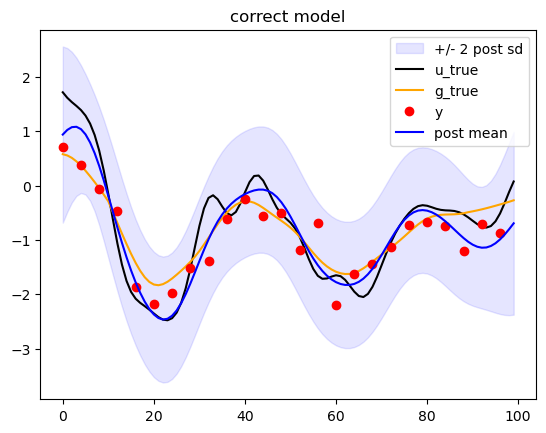

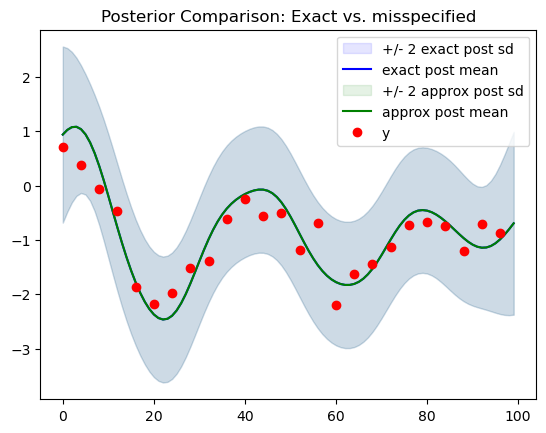

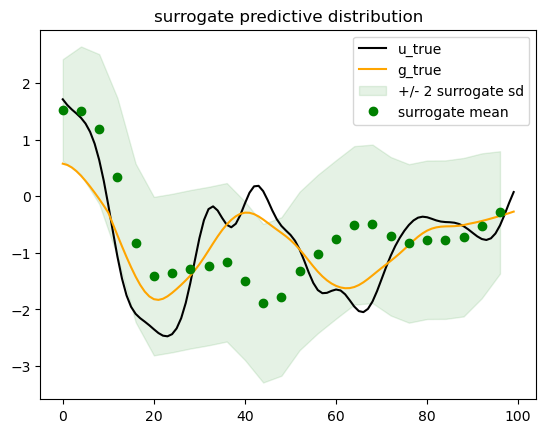

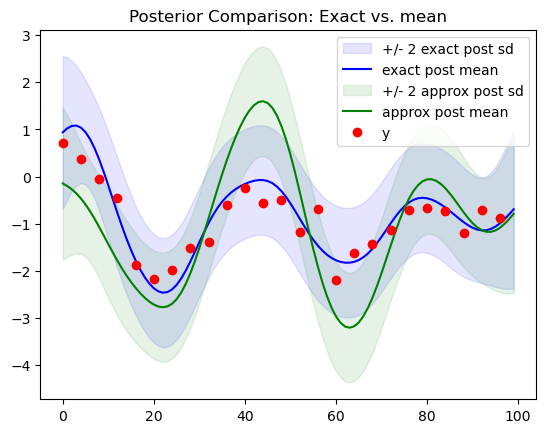

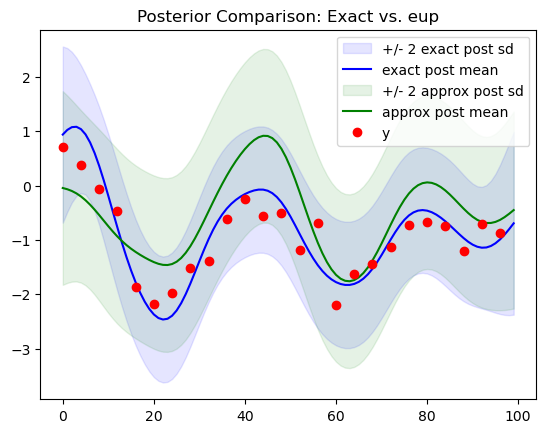

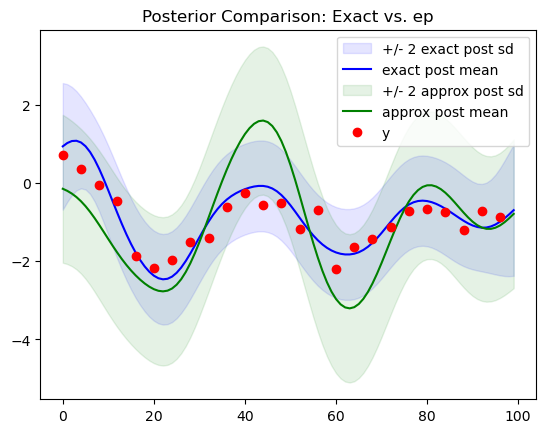

In [4]:
summarize_setup(inv_prob, test, grid, idx_obs, g_conv_true)

### Model Misspecification
We now consider modifying the above problem so that the likelihood $\mathcal{N}(y \mid Gu, \Sigma)$ is 
misspecified. In particular, we consider the same data generating process as above but now solve the 
inverse problem with the misspecified likelihood $\mathcal{N}(y \mid \alpha Gu, \Sigma)$.

In [ ]:
# Ground truth data generating process
alpha = 4.0

# Misspecified inverse problem model
inv_prob_mispec = LinGaussInvProb(rng=rng,
                                  G=alpha * inv_prob.G,
                                  m0=inv_prob.prior.mean,
                                  C0=inv_prob.prior.cov,
                                  Sig=inv_prob.noise.cov,
                                  y=inv_prob.y)

# Calibrated surrogate model
test_mispec = LinGaussTest(inv_prob_mispec, Q)

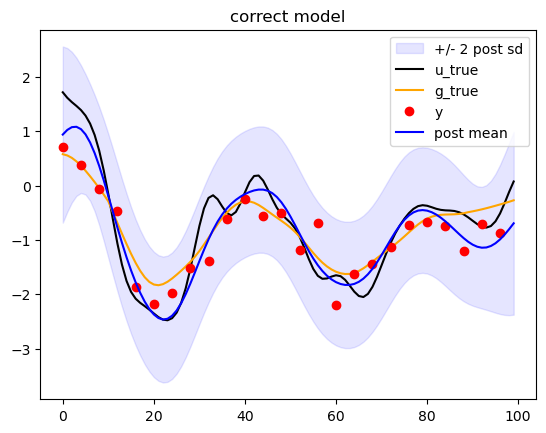

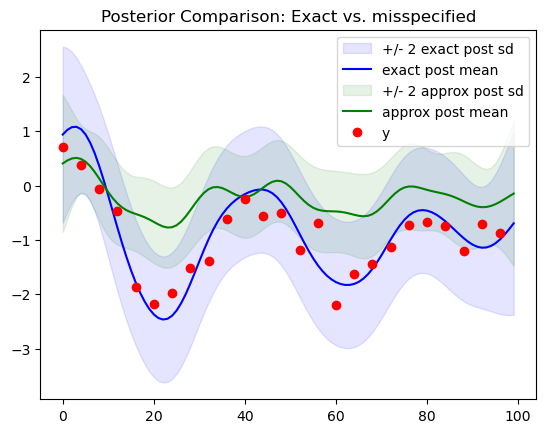

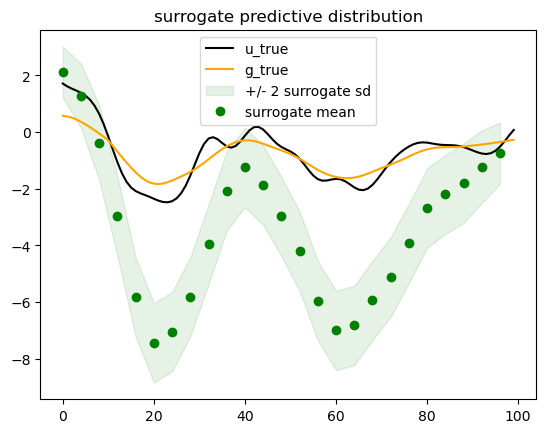

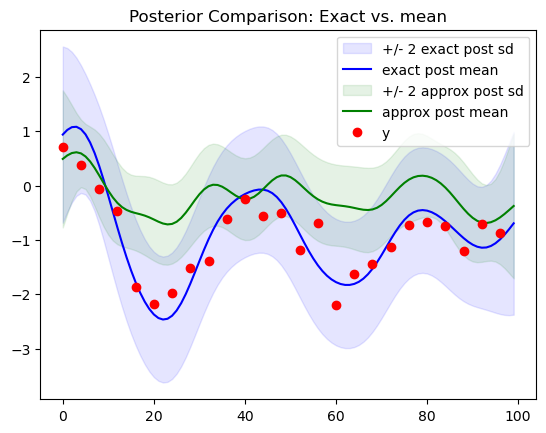

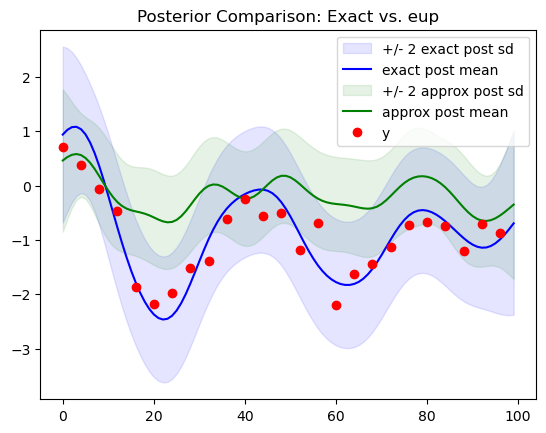

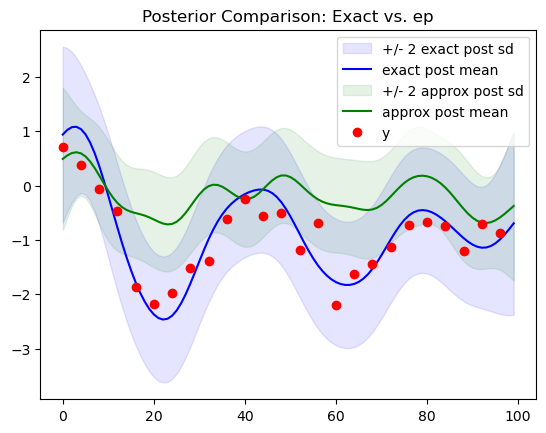

In [6]:
summarize_setup(inv_prob, test_mispec, grid, idx_obs, g_conv_true)

## Run Experiment over Replications

In [ ]:
tests, res, probs = run_coverage_test(rng, n_reps, m0=inv_prob.prior.mean, 
                                      C0=inv_prob.prior.cov, Sig=inv_prob.noise.cov, 
                                      G=inv_prob.G, Q_true=Q, Q=Q)

In [ ]:
svd_fig = inv_prob.plot_G_singular_vals()
whitened_svd_fig = inv_prob.plot_G_singular_vals(whiten=True)

display(svd_fig)
display(whitened_svd_fig)

# Surrogate Model

In [ ]:
# Construct Q so that trace(Q) = trace(Sig) (doubling total variance)
tr_Sig = np.trace(inv_prob.noise.cov)
q_floor = 1e-6
q_start = np.max(np.diag(inv_prob.noise.cov))
q = np.array([max(q_floor, q_start/2**i) for i in range(n)])
q_vars = tr_Sig * q / q.sum()

plt.semilogy(q_vars)
plt.show()

In [ ]:
"""
U, s, Vh = np.linalg.svd(inv_prob.G)

# High noise in stable directions
Q_stable = (U*q_vars) @ U.T

# High noise in unstable directions
Q_unstable = (U*q_vars[::-1]) @ U.T

# Noise proportional to prior pushforward
Q_prior = 0.5 * G @ inv_prob.prior.cov @ G.T

# All error in first left singular vector direction
idx = 0
u1 = U[idx,:]
eps = 1e-6
scaler = np.sum(s)
Q1 = 5 * scaler * np.linalg.outer(u1, u1) + eps * np.identity(inv_prob.n)
"""

In [ ]:
u_samp = inv_prob.prior.sample()
g_samp = inv_prob.G @ u_samp

r_samp = Gaussian(rng=rng, cov=Q1).sample()
g_samp_perturbed = g_samp + r_samp

plt.plot(grid, u_samp, color="black", label="u_true")
plt.plot(idx_obs, g_samp, color="orange", label="g_true")
plt.plot(idx_obs, g_samp_perturbed, color="red", label="g_true + r")
plt.legend()
plt.show()

# Run Numerical Experiments

In [ ]:
n_reps = 1
n_plot_rows = int(max(1, np.ceil(d/4)))
Q = np.trace(inv_prob.noise.cov) * np.identity(inv_prob.n)

In [ ]:
tests, res, probs = run_coverage_test(rng, n_reps, m0=inv_prob.prior.mean, 
                                      C0=inv_prob.prior.cov, Sig=inv_prob.noise.cov, 
                                      G=inv_prob.G, Q_true=Q, Q=Q)

In [ ]:
fig_cover, ax_cover = plot_coverage(
    ep_coverage=res['cover']['ep_cover_joint'],
    eup_coverage=res['cover']['eup_cover_joint'], 
    probs=probs, q_min=0.05, q_max=0.95
)

display(fig_cover)

## Looking at a Single Replicate

In [ ]:
test_idx = 0
test = tests[test_idx]


In [ ]:
print(res['mcmc']['ep_rk_w2'][test_idx])
print(res['mcmc']['ep_rkpcn90_w2'][test_idx])
print(res['mcmc']['ep_rkpcn95_w2'][test_idx])
print(res['mcmc']['ep_rkpcn99_w2'][test_idx])

## Scaling behavior as surrogate uncertainty grows

In [ ]:
from analytical_analysis import (
    plot_eigenvalue_comparison,
    lambda_exact,
    lambda_eup,
    lambda_ep,
    alpha_exact,
    alpha_eup,
    alpha_ep,
)

In [ ]:
def plot_eigenvalue_comparison(G, q_vals=None, c0=1.0, sig=1.0,
                               s_idcs=None):
    if q_vals is None:
        q_vals = np.linspace(0, 6, num=100)

    U, s, Vh = np.linalg.svd(G)
    if s_idcs is None:
        s_idcs = np.arange(0, len(s), len(s) // 3) 
    
    eig_exact = lambda_exact(s, c0=c0, sig=sig)
    eig_eup = lambda_eup(s, q_vals, c0=c0, sig=sig)
    eig_ep = lambda_ep(s, q_vals, c0=c0, sig=sig)

    eig_eup_norm = eig_eup / eig_exact
    eig_ep_norm = eig_ep / eig_exact

    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    q_over_sigma = q_vals / sig

    # eup
    ax = axs[0]
    eup_eig_plot = ax.plot(q_over_sigma, eig_eup_norm[:,s_idcs])
    ax.set_title(f'eup lambdas, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('lambda eup / lambda')

    # ep
    ax = axs[1]
    ep_eig_plot = ax.plot(q_over_sigma, eig_ep_norm[:,s_idcs])
    ax.set_title(f'ep lambdas, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('lambda ep / lambda')
    ax.legend(ep_eig_plot, s_idcs)

    plt.close()
    return fig, axs

def plot_mean_comparison(G, y, r, q_vals=None, c0=1.0, sig=1.0,
                         s_idcs=None):
    if q_vals is None:
        q_vals = np.linspace(0, 6, num=100)

    U, s, Vh = np.linalg.svd(G)
    if s_idcs is None:
        s_idcs = np.arange(0, len(s), len(s) // 3)

    alphas_exact = alpha_exact(s=s, y=y, U=U, c0=c0, sig=sig)
    alphas_eup = alpha_eup(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_ep = alpha_ep(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_eup_norm = (alphas_eup - alphas_exact) / alphas_exact
    alphas_ep_norm = (alphas_ep - alphas_exact) / alphas_exact

    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    q_over_sigma = q_vals / sig

    # eup
    ax = axs[0]
    eup_mean_plot = ax.plot(q_over_sigma, alphas_eup_norm[:,s_idcs])
    ax.set_title(f'eup alphas, r = {r}, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('relative bias')

    # ep
    ax = axs[1]
    ep_mean_plot = ax.plot(q_vals, alphas_ep_norm[:,s_idcs])
    ax.set_title(f'ep alphas, r = {r}, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('relative bias')
    ax.legend(ep_mean_plot, s_idcs)

    plt.close()
    return fig, axs

In [ ]:
c0 = 1.0
r = 0
q_over_sig_max = 10.0

In [ ]:
# small sigma
sig = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_small_sig, ax_small_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                         sig=sig, 
                                                         s_idcs=None, 
                                                         q_vals=q_vals)

# large sigma
sig = 10.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_big_sig, ax_big_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                     sig=sig, 
                                                     s_idcs=None, 
                                                     q_vals=q_vals)

display(fig_small_sig)
display(fig_big_sig)
plt.close()

In [ ]:
# TODO: some other options:
# - Fix sig and vary ratio r/q

# small bias
r = -0.1
sig = 1.0 
q_vals = np.linspace(0, sig * q_over_sig_max, num=100)
fig_mean_small_r, ax_mean_small_r = plot_mean_comparison(G=test.G, y=test.y, r=r, 
                                                         q_vals=q_vals, 
                                                         c0=c0, sig=sig,
                                                         s_idcs=None)
# ax_mean_small_r[0].plot(q_vals/sig, np.abs(r/q_vals), color='r', linestyle='-')

# big bias
r = -10.0
sig = 10.0 
q_vals = np.linspace(0, sig * q_over_sig_max, num=100)
fig_mean_big_r, ax_mean_big_r = plot_mean_comparison(G=test.G, y=test.y, r=r, 
                                                     q_vals=q_vals, 
                                                     c0=c0, sig=sig,
                                                     s_idcs=None)

display(fig_mean_small_r)
display(fig_mean_big_r)

In [ ]:
# Fixing ratio r/q [so emulator is always calibrated] and varying 
# q/sigma.

sig = 1.0 
r_over_q = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
r_vals = q_vals.copy()
nq = len(q_vals)
nr = nq

In [ ]:
U, s, Vh = np.linalg.svd(G)
ns = len(s)
s_idcs = np.arange(0, len(s), len(s) // 3)
y = test.y.copy()

alphas_exact = alpha_exact(s=s, y=y, U=U, c0=c0, sig=sig)
alphas_eup_norm = np.empty((nr, nq, ns))
alphas_ep_norm = np.empty((nr, nq, ns))

for i, r in enumerate(r_vals):
    alphas_eup = alpha_eup(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_ep = alpha_ep(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_eup_norm[i] = alphas_eup - alphas_exact
    alphas_ep_norm[i] = alphas_ep - alphas_exact



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
q_over_sigma = q_vals / sig

# eup
ax = axs[0]
eup_mean_plot = ax.plot(q_over_sigma, alphas_eup_norm[...,0].T)
ax.set_title(f'eup alphas, r = {r}, sigma={sig}')
ax.set_xlabel('q')
ax.set_ylabel('relative bias')

# ep
ax = axs[1]
ep_mean_plot = ax.plot(q_vals, alphas_ep_norm[...,0].T)
ax.set_title(f'ep alphas, r = {r}, sigma={sig}')
ax.set_xlabel('q')
ax.set_ylabel('relative bias')
ax.legend(ep_mean_plot, s_idcs)

plt.close()

display(fig)